# Рекомендация тарифов клиентам мобильного оператора

Имеются данные о поведении клиентов мобильного оператора в зависимости от выбранного ими тарифа. Нужно построить модель для задачи классификации, которая выберет подходящий тариф, с максимально большим значением *accuracy* (не ниже 0.75). 

Импорт библиотек, которые потребуются для выполнения исследования:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
import warnings
warnings.filterwarnings('ignore')

## Загрузка датасета

In [2]:
users_behavior = pd.read_csv('/datasets/users_behavior.csv')

Получение данных о первых 10 строках таблицы **users_behavior**:

In [3]:
users_behavior.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


Общая информация о данных таблицы **users_behavior**:

In [4]:
users_behavior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


В датафрейме **users_behavior** представлена информация о поведении клиентов оператора сотовой связи, перешедших на новые тарифы, за месяц. Он состоит из следующих столбцов: 

- **calls** - количество звонков;
- **minutes** - суммарная длительность звонков в минутах;
- **messages** - количество sms-сообщений;
- **mb_used** - израсходованный интернет-трафик в Мб;
- **is_ultra** - каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

Общее количество объектов - 3 214. Пропусков нет. Все данные вещественного типа, за исключением столбца **is_ultra** (он целочисленный).

#### Анализ признаков

Теперь рассмотрим отдельно каждый столбец на предмет наличия ошибок в данных, аномалий и пр. Начнем с основного показателя (в дальнейшем - целевой переменной) - тарифа пользователя.

**is_ultra - тариф пользователя («Ультра» — 1, «Смарт» — 0)**

In [5]:
users_behavior['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

In [6]:
users_behavior['is_ultra'].value_counts(normalize = True)

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

Почти 70% пользователей (2229 человек) пользуются тарифом "Смарт". Остальные (985) - тарифом "Ультра".

Пропусков и некорректных значений в столбце нет.

**calls - количество звонков**

In [7]:
users_behavior['calls'].describe()

count    3214.000000
mean       63.038892
std        33.236368
min         0.000000
25%        40.000000
50%        62.000000
75%        82.000000
max       244.000000
Name: calls, dtype: float64

В среднем пользователь делает 63 звонка в месяц. Медианное значение - 62.

Построим график распределения:

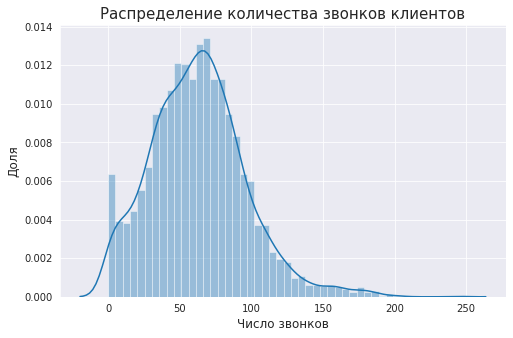

In [8]:
plt.figure(figsize=(8, 5))
sns.set_style("darkgrid")
fig = sns.distplot(users_behavior['calls'], kde = True, bins = np.linspace(start = 0, stop = 250, num = 50))
fig.set_title("Распределение количества звонков клиентов", fontsize = 15)
fig.set_xlabel("Число звонков", fontsize = 12)
fig.set_ylabel("Доля", fontsize = 12)

plt.show()

Распределение визуально выглядит как нормальное, скошенное вправо. Аномальных значений нет, однако больше ожидаемой доля пользователей, вообще не совершавших звонки (левый край распределения).

Рассмотрим указанный признак в разрезе тарифа клиентов:

In [9]:
users_behavior.query('is_ultra == 0')['calls'].mean().round(3)

58.463

In [10]:
users_behavior.query('is_ultra == 1')['calls'].mean().round(3)

73.393

Среднее количество звонков среди пользователей тарифа "Ультра" выше: 73 против 58.

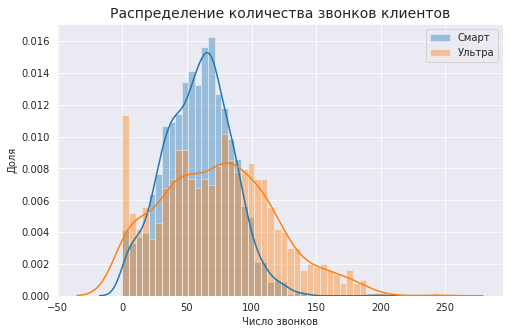

In [11]:
plt.figure(figsize=(8, 5))
fig1 = sns.distplot(users_behavior.query('is_ultra == 0')['calls'], kde = True, \
                    bins = np.linspace(start = 0, stop = 250, num = 50), label = 'Смарт') 
fig2 = sns.distplot(users_behavior.query('is_ultra == 1')['calls'], kde = True, \
                    bins = np.linspace(start = 0, stop = 250, num = 50), label = 'Ультра')  
fig2.set_title("Распределение количества звонков клиентов", fontsize = 14)
fig2.set_ylabel("Доля", fontsize = 10)
fig2.set_xlabel("Число звонков")
plt.legend()
plt.show()

Кривые плотностей распределения выглядят по-разному. Оба распределения похожи на нормальные. Кривая для пользователей "Ультры" гораздо более пологая: выше доля людей, совершивших много звонков. Также заметно, что доля вообще не звонивших пользователей высока именно среди пользователей "Ультры". 

**minutes - суммарная длительность звонков в минутах**

In [12]:
users_behavior['minutes'].describe()

count    3214.000000
mean      438.208787
std       234.569872
min         0.000000
25%       274.575000
50%       430.600000
75%       571.927500
max      1632.060000
Name: minutes, dtype: float64

В среднем пользователь разговаривает 438 минут в месяц (медианное значение также близко - 430 минут). Аномальных значений и пропусков нет.

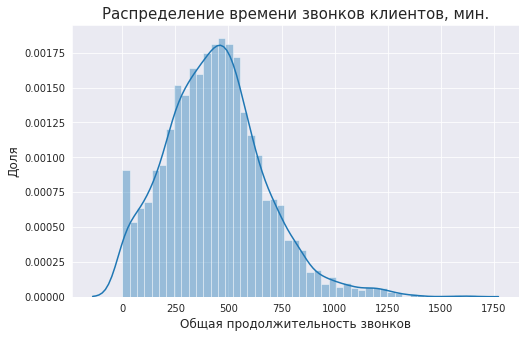

In [13]:
plt.figure(figsize=(8, 5))
fig = sns.distplot(users_behavior['minutes'], kde = True, bins = np.linspace(start = 0, stop = 1700, num = 50))
fig.set_title("Распределение времени звонков клиентов, мин.", fontsize = 15)
fig.set_xlabel("Общая продолжительность звонков", fontsize = 12)
fig.set_ylabel("Доля", fontsize = 12)

plt.show()

Распределение выглядит практически так же, как и у признака **calls**, что может указывать на их высокую корреляцию.

Построим распределения суммарного времени звонков в разрезе тарифа клиентов:

In [14]:
users_behavior.query('is_ultra == 0')['minutes'].mean().round(3)

405.943

In [15]:
users_behavior.query('is_ultra == 1')['minutes'].mean().round(3)

511.225

Средняя суммарная продолжительность звонков существенно выше на тарифе "Ультра".

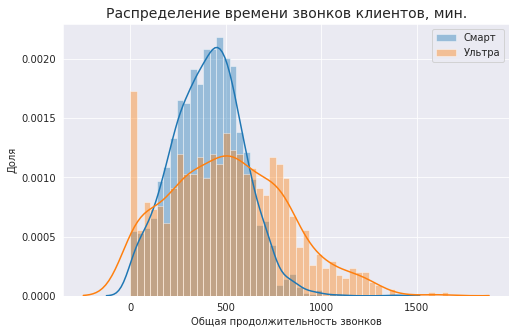

In [16]:
plt.figure(figsize=(8, 5))
fig1 = sns.distplot(users_behavior.query('is_ultra == 0')['minutes'], kde = True, \
                    bins = np.linspace(start = 0, stop = 1700, num = 50), label = 'Смарт') 
fig2 = sns.distplot(users_behavior.query('is_ultra == 1')['minutes'], kde = True, \
                    bins = np.linspace(start = 0, stop = 1700, num = 50), label = 'Ультра')  
fig2.set_title("Распределение времени звонков клиентов, мин.", fontsize = 14)
fig2.set_ylabel("Доля", fontsize = 10)
fig2.set_xlabel("Общая продолжительность звонков")
plt.legend()
plt.show()

Характер распределений такой же, как и у признака **calls**: "Ультра" более пологая (выше разброс от среднего) и с очень высокой долей пользователей, не совершавших звонки вообще.

**messages - количество sms-сообщений**

In [17]:
users_behavior['messages'].describe()

count    3214.000000
mean       38.281269
std        36.148326
min         0.000000
25%         9.000000
50%        30.000000
75%        57.000000
max       224.000000
Name: messages, dtype: float64

В среднем пользователь делает 38 сообщений в месяц. Медианное значение - 30.

Построим график распределения:

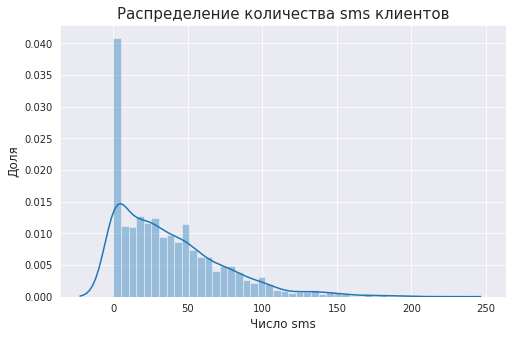

In [18]:
plt.figure(figsize=(8, 5))
sns.set_style("darkgrid")
fig = sns.distplot(users_behavior['messages'], kde = True, bins = np.linspace(start = 0, stop = 250, num = 50))
fig.set_title("Распределение количества sms клиентов", fontsize = 15)
fig.set_xlabel("Число sms", fontsize = 12)
fig.set_ylabel("Доля", fontsize = 12)

plt.show()

Распределение не является нормальным. Большая часть пользователей либо не пользуется sms вообще, либо отправляет их минимальное количество.

Рассмотрим указанный признак в разрезе тарифа клиентов:

In [19]:
users_behavior.query('is_ultra == 0')['messages'].mean().round(3)

33.384

In [20]:
users_behavior.query('is_ultra == 1')['messages'].mean().round(3)

49.363

Среднее количество sms на тарифе "Ультра" снова выше: 49 против 33.

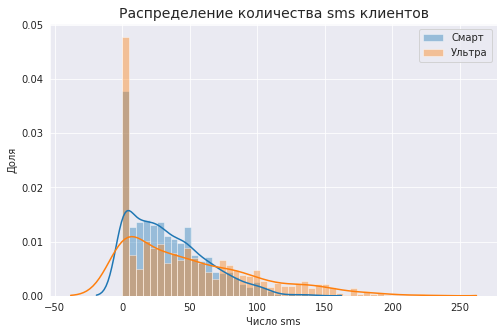

In [21]:
plt.figure(figsize=(8, 5))
fig1 = sns.distplot(users_behavior.query('is_ultra == 0')['messages'], kde = True, \
                    bins = np.linspace(start = 0, stop = 250, num = 50), label = 'Смарт') 
fig2 = sns.distplot(users_behavior.query('is_ultra == 1')['messages'], kde = True, \
                    bins = np.linspace(start = 0, stop = 250, num = 50), label = 'Ультра')  
fig2.set_title("Распределение количества sms клиентов", fontsize = 14)
fig2.set_ylabel("Доля", fontsize = 10)
fig2.set_xlabel("Число sms")
plt.legend()
plt.show()

Расределения выглядят более похожими друг на друга, чем в случае числа звонков и их суммарной продолжительности, тем не менее прослеживаются те же закономерности: более пологая кривая для "Ультры" и пики в левой части графиков, соответствующие минимальным значениям признака.

**mb_used - израсходованный интернет-трафик в Мб**

In [22]:
users_behavior['mb_used'].describe()

count     3214.000000
mean     17207.673836
std       7570.968246
min          0.000000
25%      12491.902500
50%      16943.235000
75%      21424.700000
max      49745.730000
Name: mb_used, dtype: float64

В среднем пользователь использует 16 943 Мб трафика в месяц. Медианное значение - 17 207.

Построим график распределения:

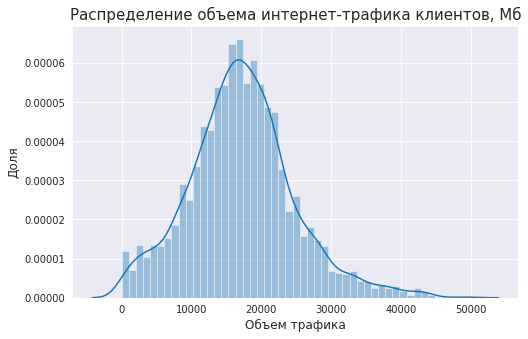

In [23]:
plt.figure(figsize=(8, 5))
sns.set_style("darkgrid")
fig = sns.distplot(users_behavior['mb_used'], kde = True, bins = np.linspace(start = 0, stop = 50000, num = 50))
fig.set_title("Распределение объема интернет-трафика клиентов, Мб", fontsize = 15)
fig.set_xlabel("Объем трафика", fontsize = 12)
fig.set_ylabel("Доля", fontsize = 12)

plt.show()

Распределение выглядит как нормальное. Аномальных значений нет. 

Рассмотрим указанный признак в разрезе тарифа клиентов:

In [24]:
users_behavior.query('is_ultra == 0')['mb_used'].mean().round(3)

16208.467

In [25]:
users_behavior.query('is_ultra == 1')['mb_used'].mean().round(3)

19468.823

Пользователи тарифа "Ультра" в среднем используют больше интернет-трафика: 19 468 Мб против 16 208 Мб.

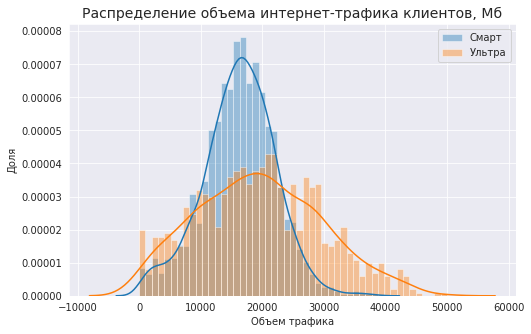

In [26]:
plt.figure(figsize=(8, 5))
fig1 = sns.distplot(users_behavior.query('is_ultra == 0')['mb_used'], kde = True, \
                    bins = np.linspace(start = 0, stop = 50000, num = 50), label = 'Смарт') 
fig2 = sns.distplot(users_behavior.query('is_ultra == 1')['mb_used'], kde = True, \
                    bins = np.linspace(start = 0, stop = 50000, num = 50), label = 'Ультра')  
fig2.set_title("Распределение объема интернет-трафика клиентов, Мб", fontsize = 14)
fig2.set_ylabel("Доля", fontsize = 10)
fig2.set_xlabel("Объем трафика")
plt.legend()
plt.show()

Оба распределения визуально похожи на нормальные. Криваая "Ультры" вновь значительно более пологая, диапазон принимаемых значений у нее шире. Аномалий нет.

**Корреляция признаков**

Проверим предположение о высокой корреляции призаков **calls** и **minutes**, сделанное выше. Построим парные графики и матрицу корреляции:

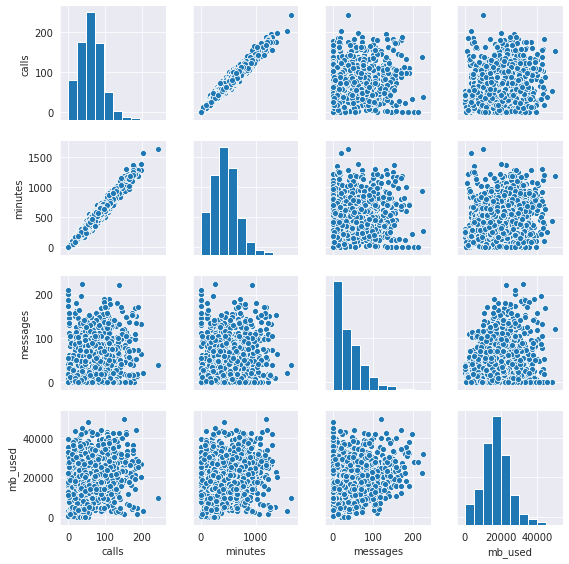

In [27]:
sns.pairplot(users_behavior.drop(['is_ultra'], axis = 1), height = 2)
plt.show()

In [28]:
cm = users_behavior.corr()

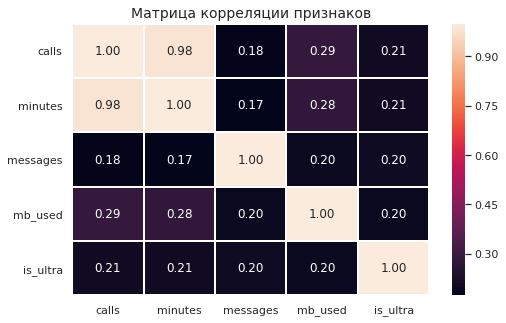

In [29]:
sns.set(style = 'white')
plt.figure(figsize = (8, 5))
plt.title('Матрица корреляции признаков', fontsize = 14)
ax = sns.heatmap(cm, annot = True, linewidths = 1, linecolor = 'white', fmt = '.2f')
plt.show()

На парном графике четко видна линейная зависимость признаков **calls** и **minutes**. Коэффициент корреляции близок к единице, что подтверждает сделанный вывод. Других сильно коррелирующих признаков нет. На целевую переменную влияют все признаки примерно в равной степени с коэффициентом корреляции 0,20-0,21.

**Вывод**

Целевая переменная **is_ultra** - тариф пользователя - распределена в соотношении 70:30. Распределение остальных признаков близко к нормальному, за исключением столбца **message**, который говорит о том, что пользователи почти перестали пользоваться сервисами отправки sms.

Диапазон значений признаков, принимаемых пользователями тарифа "Ультра", несколько выше по сравнению с клиентами на "Смарте". Выше и удаленность зачений от среднего (кривые распределения выглядят более полого). Средние значения признаков также выше на "Ультре".

Коэффициент корреляции между переменными **calls** и **minutes** составляет 0,98, что говорит об их полной взаимозависимости. В дальнейших разделах будем обучать и тестировать модели как на полном датасете, так и исключив один из зависимых признаков. В зависимости от результата примем решение об удалении одного из столбцов из таблицы.

## Разбивка данных на выборки

Целевой признак в рассматриваемой задаче - это тариф клиента:

In [30]:
target = users_behavior['is_ultra']
features = users_behavior.drop('is_ultra', axis = 1)
features_mod = users_behavior.drop(['is_ultra', 'minutes'], axis = 1)

Разделим данные на обучающую, валидационную и тестовую выборки в пропорции 60:20:20 соответственно. Классы сбалансируем.

In [31]:
features_train, features_valid, target_train, target_valid = \
                                                        train_test_split(features, target, test_size = 0.4, 
                                                        random_state = 12345, stratify = target)
features_valid, features_test, target_valid, target_test = \
                                                        train_test_split(features_valid, target_valid, test_size = 0.5, 
                                                        random_state = 12345, stratify = target_valid)

features_train_mod, features_valid_mod, target_train, target_valid = \
                                                        train_test_split(features_mod, target, test_size = 0.4, 
                                                        random_state = 12345, stratify = target)
features_valid_mod, features_test_mod, target_valid, target_test = \
                                                        train_test_split(features_valid_mod, target_valid, test_size = 0.5, 
                                                        random_state = 12345, stratify = target_valid)

Размерность выборок удовлетворяет указанным выше пропорциям:

In [32]:
display(features_train.shape, target_train.shape[0])
display(features_valid.shape, target_valid.shape[0])
display(features_test.shape, target_test.shape[0])

(1928, 4)

1928

(643, 4)

643

(643, 4)

643

In [33]:
display(features_train_mod.shape, target_train.shape[0])
display(features_valid_mod.shape, target_valid.shape[0])
display(features_test_mod.shape, target_test.shape[0])

(1928, 3)

1928

(643, 3)

643

(643, 3)

643

## Исследование моделей машинного обучения

Поскольку требуется спрогнозировать качественный признак - выбор того или иного тарифа, - будем использовать модели для решения задачи классификации: решающее дерево, случайный лес и логистическую регрессию.

**Модель логистической регрессии**

Обучим модель на тренировочной выборке и проверим ее качество на валидационной выборке (как на полном датасете, так и с удаленным столбцом):

In [34]:
def lr(f_train, t_train, f_val, t_val):
# функция принимает на вход четыре выборки: на первых двух обучает, на последних тестирует качество
# выводит значение accuracy 

    model_lr = LogisticRegression(random_state = 12345) 
    model_lr.fit(f_train, t_train)
    result = model_lr.score(f_val, t_val).round(5)
    print("Accuracy модели логистической регрессии:", result)

In [35]:
lr(features_train, target_train, features_valid, target_valid)

Accuracy модели логистической регрессии: 0.71851


In [36]:
lr(features_train_mod, target_train, features_valid_mod, target_valid)

Accuracy модели логистической регрессии: 0.71851


Разницы в показателе accuracy для полного и сокращенного датасета нет.

**Модель решающего дерева**

Обучим модель и проверим ее качество на тех же выборках. Гиперпараметр модели - глубину дерева - передадим функции в качестве параметра:

In [37]:
def dt(f_train, t_train, f_val, t_val, d):
# функция принимает на вход четыре выборки (на первых обучает, на последних тестирует качество), 
# а также максимальную глубину дерева
# выводит лучшее значение accuracy и глубину, на которой оно было достигнуто

    best_model = None
    best_result = 0
    best_depth = 0
    for depth in range(1, d + 1):
        model_dt = DecisionTreeClassifier(max_depth = depth, random_state = 12345) 
        model_dt.fit(f_train, t_train) 
        predictions_valid = model_dt.predict(f_val)
        result = accuracy_score(t_val, predictions_valid).round(5) 

        if result > best_result:
            best_model = model_dt 
            best_result = result 
            best_depth = depth
            
    print('Максимальная глубина дерева:', d)
    print('Accuracy наилучшей модели решающего дерева:', best_result) 
    print("Значение глубины:", best_depth)

Посмотрим, на каком из значений глубины модель даст лучший результат:

In [38]:
dt(features_train, target_train, features_valid, target_valid, 15)

Максимальная глубина дерева: 15
Accuracy наилучшей модели решающего дерева: 0.80249
Значение глубины: 8


In [39]:
dt(features_train_mod, target_train, features_valid_mod, target_valid, 15)

Максимальная глубина дерева: 15
Accuracy наилучшей модели решающего дерева: 0.79005
Значение глубины: 8


Очевидно, нет смысла строить слишком глубокое дерево. Лучшая точность (0,80249) достигается на глубине 8. Для датафрейма с изначальным количеством столбцов она на 0,012 выше. 

**Модель случайного леса**

Напишем аналогичную функцию, только в качестве параметра будем передавать не только глубину, но и количество деревьев.

In [40]:
def rf(f_train, t_train, f_val, t_val, d, n_est):
# функция принимает на вход четыре выборки (на первых обучает, на последних тестирует качество), 
# а также глубину и максимальное число деревьев
# выводит лучшее значение accuracy, глубину и количество деревьев, на котором оно было достигнуто

    best_model = None
    best_result = 0
    best_n_est = 0
    for est in range(1, n_est + 1):
        for depth in range(1, d + 1):
            model_rf = RandomForestClassifier(random_state = 12345, n_estimators = est, max_depth = depth) 
            model_rf.fit(f_train, t_train) 
            result = model_rf.score(f_val, t_val).round(5) 
        
            if result > best_result:
                best_model = model_rf 
                best_result = result 
                best_n_est = est
                best_depth = depth

    print('Максимальное число деревьев:', n_est)
    print("Accuracy наилучшей модели случайного леса:", best_result)
    print("Число деревьев:", best_n_est)
    print("Значение глубины:", best_depth)

Определим, при каких параметрах глубины и числа деревьев достигается лучшая точность:

In [41]:
rf(features_train, target_train, features_valid, target_valid, 20, 50)

Максимальное число деревьев: 50
Accuracy наилучшей модели случайного леса: 0.82271
Число деревьев: 39
Значение глубины: 9


In [42]:
rf(features_train_mod, target_train, features_valid_mod, target_valid, 20, 50)

Максимальное число деревьев: 50
Accuracy наилучшей модели случайного леса: 0.8196
Число деревьев: 26
Значение глубины: 9


На данных исходного датасета точность оказалась на 0,003 выше, чем на модифицированном. Оптимальное число деревьев разное для исходного и модифицированного датасета.

**Вывод**

Для решения задачи классификации построены три модели: логистической регрессии, решающего дерева и случайного леса. Модели обучены на тренировочной выборке; качество проверено на валидационной выборке.

- лучшую точность показала **модель случайного леса** с числом деревьев 39 и глубиной 9: **0,82271**.
- промежуточный результат у **модели решающего дерева** с глубиной 8: **0,80249**.
- ниже всего точность у **модели логистической регрессии**: **0.71851**.

На данных исходного датафрейма точность моделей решающего дерева и случайного леса немного выше (на 0,012 и 0,003 соответственно), чем на данных датафрейма с удаленным признаком **minutes**.

## Проверка моделей на тестовой выборке

Проверим работу моделей на тестовой выборке. Для обучения используем объединение тренировочной и валидационной выборок как для полного, так и модифицированного датасета. В качестве гиперпараметров передадим те, что давали лучший результат на предыдущем шаге.

In [43]:
feat_tr = pd.concat([features_train, features_valid])
feat_tr_mod = pd.concat([features_train_mod, features_valid_mod])   
targ_tr = pd.concat([target_train, target_valid])  

**Модель логистической регрессии**:

In [44]:
model_lr1 = LogisticRegression(random_state = 12345) 
model_lr1.fit(feat_tr, targ_tr)
result = model_lr1.score(features_test, target_test).round(5)
print("Accuracy модели логистической регрессии для исходного датафрейма:", result)

Accuracy модели логистической регрессии для исходного датафрейма: 0.70607


In [45]:
model_lr2 = LogisticRegression(random_state = 12345) 
model_lr2.fit(feat_tr_mod, targ_tr)
result = model_lr2.score(features_test_mod, target_test).round(5)
print("Accuracy модели логистической регрессии для модифицированного датафрейма:", result)

Accuracy модели логистической регрессии для модифицированного датафрейма: 0.7325


**Модель решающего дерева**

In [46]:
model_dt1 = DecisionTreeClassifier(max_depth = 8, random_state = 12345) 
model_dt1.fit(feat_tr, targ_tr) 
predictions = model_dt1.predict(features_test)
result = accuracy_score(target_test, predictions).round(5) 
print("Accuracy модели решающего дерева для исходного датафрейма:", result)

Accuracy модели решающего дерева для исходного датафрейма: 0.80715


In [47]:
model_dt2 = DecisionTreeClassifier(max_depth = 8, random_state = 12345) 
model_dt2.fit(feat_tr_mod, targ_tr) 
predictions = model_dt2.predict(features_test_mod)
result = accuracy_score(target_test, predictions).round(5) 
print("Accuracy модели решающего дерева для модифицированного датафрейма:", result)

Accuracy модели решающего дерева для модифицированного датафрейма: 0.79782


**Модель случайного леса**

In [48]:
model_rf1 = RandomForestClassifier(random_state = 12345, n_estimators = 39, max_depth = 9) 
model_rf1.fit(feat_tr, targ_tr) 
result = model_rf1.score(features_test, target_test).round(5) 
print("Accuracy модели случайного леса для исходного датафрейма:", result)

Accuracy модели случайного леса для исходного датафрейма: 0.82893


In [49]:
model_rf2 = RandomForestClassifier(random_state = 12345, n_estimators = 26, max_depth = 9) 
model_rf2.fit(feat_tr_mod, targ_tr) 
result = model_rf2.score(features_test_mod, target_test).round(5) 
print("Accuracy модели случайного леса для модифицированного датафрейма:", result)

Accuracy модели случайного леса для модифицированного датафрейма: 0.82271


**Вывод**

На датафрейме, из которого был удален столбец **minutes**, лучше себя показала модель логистической регрессии. Модели решающего дерева и случайного леса дали более высокую точность на исходном датафрейме.

На тестовой выборке лучший результат вновь оказался у **модели случайного леса**. Ее точность составила **0,82893**, что означает правильность предсказания в почти 82,9% случаев. 

Второе место у **модели решающего дерева**: 0,80715

Самая низкая точность у **логистической регрессии**: 0,73250.

Требуемое по условию задачи значение **accuracy** достигнуто для моделей случайного леса и решающего дерева.

## Проверка модели на адекватность

Будем считать, что модель адекватна, если ее прогноз лучше, чем вероятность принадлежности клиента к группе пользователей тарифа "Смарт", рассчитанная только на основании знания пропорций в исходной выборке.

In [50]:
round(users_behavior.loc[users_behavior['is_ultra'] == 0].shape[0] / users_behavior.shape[0], 5)

0.69353

Доля пользователей с тарифом "Смарт" в выборке составляет 69,3%. Таким образом, классифицировав случайного клиента как пользователя тарифа "Смарт", мы сделаем верное предположение в 69,3% случаев. При этом прогноз лучшей поcтроенной модели верен в 82,9% случаев, что подтверждает ее адекватность.  

Проверим модель на адекватность, сравнив ее с результатами работы классификатора **DummyClassifier**. Если ее способность к классификации будет выше, чем результат примитивных прогнозов **DummyClassifier**, это будет говорить об адекватности построенной модели.

In [51]:
strategies = ['stratified', 'most_frequent', 'prior', 'uniform'] 
  
dummy_results = [] 
for s in strategies: 
    dc = DummyClassifier(strategy = s, random_state = 12345)
    dc.fit(feat_tr, targ_tr) 
    result = dc.score(features_test, target_test).round(5) 
    dummy_results.append({s: result}) 

display(dummy_results)

[{'stratified': 0.55677},
 {'most_frequent': 0.69362},
 {'prior': 0.69362},
 {'uniform': 0.49456}]

Ни одна стратегия, использующаяся в **DummyClassifier**, не показала результата, сравнимого с работой построенной модели, что говорит о ее адекватности.

## Вывод

В работе решалась задача классификации пользователей оператора сотовой связи на выборке из 3 214 клиентов. 

Целевая переменная - тариф пользователя - распределена в соотношении 70:30. Распределение остальных признаков оказалось близким к нормальному, за исключением столбца **message**, отвечающего за показатель отправки sms.

Диапазон значений признаков пользователей тарифа "Ультра" несколько выше по сравнению с клиентами на "Смарте". Выше для них и удаленность от среднего: кривые распределения выглядят более полого. Средние значения признаков также выше на "Ультре".

Обнаружена высокая зависимость между переменными **calls** и **minutes** (коэффициент корреляции 0,98).  связи с этим обучение и тестирование моделей осуществлялось как на целом датафрейме, так и на датафрейме с удаленным столбцом **minutes**.

Для решения задачи классификации были построены три модели: логистической регрессии, решающего дерева и случайного леса. Сначала модели были обучены на тренировочной и проверены на валидационной выборках. На данных исходного датафрейма точность моделей решающего дерева и случайного леса оказалась немного выше (на 0,012 и 0,003 соответственно), чем на данных датафрейма с удаленным признаком **minutes**. Модель логистической регрессии показала одинаковый результат.

Лучшую точность показала **модель случайного леса** с числом деревьев 39 и глубиной 9: 0,82271. Второй результат у **модели решающего дерева** с глубиной 8: 0,80249. Хуже всего точность оказалась у **модели логистической регрессии**: 0.71851.

Затем модели были обучены на объединении тренировочной и валидационной выборок. В качестве гиперпараметров выбраны те, на котрых был получно лучшее значение accuracy на предыдущем обучении.

На тестовой выборке лучший результат вновь оказался у **модели случайного леса**. Ее точность составила 0,82893, что означает правильность прогнозирования в почти 82,9% случаев. Несколько уступает ей модель **решающего дерева**: 0,80715. Самая низкая точность у **логистической регрессии**: 0,73250. Модели решающего дерева и случайного леса дали более высокую точность на исходном датафрейме, логистической регрессии - на модифицированном.

Требуемое по условию задачи значение accuracy более 0,75 достигнуто для моделей случайного леса и решающего дерева.

Проверка на адекватность лучшей из построенных моделей пройдена успешно.